<a href="https://colab.research.google.com/github/binh0804/NoteBook_KLTN_Crystal/blob/main/%5BTrainAISFormer%5D_KLTN_T%C3%8CM_HI%E1%BB%82U_V%E1%BB%80_NH%E1%BA%ACN_D%E1%BA%A0NG_H%C3%8CNH_TH%C3%81I_TINH_TH%E1%BB%82_S%E1%BB%AC_D%E1%BB%A4NG_H%E1%BB%8CC_M%C3%81Y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
---
Khóa luận tốt nghiệp kỹ sư Công nghệ thông tin
# **TÌM HIỂU VỀ NHẬN DẠNG HÌNH THÁI TINH THỂ SỬ DỤNG HỌC MÁY**
---
##### SVTH:
###### Phạm Phúc Bình - 20110252
###### Hứa Lộc Sơn - 20110712
---
## Thư viện và mô hình
##### Thư viện sử dụng: Detectron2 - Facebook AI Research
##### Mô hình sử dụng: R101-FPN (mask_rcnn_R_101_FPN_3x)
---
## Dữ liệu
- Tập train: 32 ảnh, mỗi ảnh 50-100 tinh thể
- Tập test: 8 ảnh
---
## Các thông số huấn luyện mô hình
#### MAX-ITER = 2500
#### BASE_LR = 0.001

#### SOLVER.STEPS = (800,1500,2200)
#### SOLVER.GAMMA = 0.005

#### NUM_CLASSES = 1

---
## **Hướng dẫn chạy**
#### **Chọn `Runtime > Run All`**

<img src="https://github.com/binh0804/images_repository/blob/main/Image_on_Colab_TLCN/run_all.png?raw=true" width="500">

---
---


# Kết nối với Google Drive (optional)

In [ ]:
#Connect to drive
# from google.colab import drive
# drive.mount('/content/drive')

# Khai báo bảng mã sử dụng (UTF-8)



In [ ]:
# Import thư viện về localize, cài đặt encoding để không bị lỗi khi sử dụng các kí tự có dấu
import locale
def custom_getpreferredencoding(*args, **kwargs):
    return "UTF-8"
locale.getpreferredencoding = custom_getpreferredencoding

# Cài đặt các thư viện
- COCO API (pycocotools)
- Detectron2 (và các dependencies khác) để cấu hình các mô hình theo config file
- AIStron để chuẩn hóa quá trình train cho nhiều mô hình

In [ ]:
# !pip install pytorch==1.10.0 torchvision==0.11.0 cudatoolkit=11.3 -c pytorch

# coco api
!pip install pycocotools
#Detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# other dependencies
!pip install ninja yacs cython matplotlib tqdm shapely
!pip install opencv-python
!pip install sklearn
!pip install scikit-image
!pip install timm

# aistron
!pip install git+https://github.com/trqminh/aistron


# Clone source code của thư viện AIStron

In [ ]:
!git clone https://github.com/trqminh/aistron.git

Cloning into 'aistron'...
remote: Enumerating objects: 884, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 884 (delta 98), reused 145 (delta 61), pack-reused 677
Receiving objects: 100% (884/884), 1.92 MiB | 4.63 MiB/s, done.
Resolving deltas: 100% (459/459), done.
Cloning into 'crystal-datasets'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 105 (delta 22), reused 98 (delta 17), pack-reused 0
Receiving objects: 100% (105/105), 18.02 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (22/22), done.


# Tải dataset

In [ ]:
# Clone data from Github, gồm ảnh và annotation
!git clone https://github.com/hualocson/crystal-datasets.git
import os
# Tạo thư mục chứa data
train_dir = "/content/datasets/train"
test_dir = "/content/datasets/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
# Copy file
!cp -r /content/crystal-datasets/datasets/train/* /content/datasets/train/
!cp -r /content/crystal-datasets/datasets/test/* /content/datasets/test/

# Import một số thư viện thông dụng

In [ ]:
import sys, distutils.core, torch
import os, json, cv2, random
import numpy as np

# Import các thư viện đã cài đặt

In [ ]:
#Thiết lập một số hàm cần dùng từ detectron2

# Thiết lập Detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# Import một số chức năng cần dùng của Detectron2 như:
# Model Zoo : dùng để tải các tài nguyên hoặc
# tệp huấn luyện sẵn của các mô hình Detectron2
from detectron2 import model_zoo

# DefaultPredictor: Dùng để thiết lập công cụ dự đoán (suy luận)
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from aistron.data.datasets.coco_amodal import register_aistron_cocolike_instances
from aistron.evaluation.amodal_evaluation import (
    AmodalInstanceEvaluator
)
from aistron.utils.visualizer import AmodalVisualizer

# Khai báo hàm đánh giá mô hình

In [ ]:
from aistron.data import AmodalDatasetMapper
from aistron.evaluation import AmodalInstanceEvaluator
from aistron.config import add_aistron_config
from detectron2.evaluation import (
    DatasetEvaluators)
def build_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["coco_amodal"]:
        evaluator_list.append(AmodalInstanceEvaluator(dataset_name, output_dir=output_folder))
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    elif len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)


# Một số hàm để khai báo dataset cho thư viện AIStron dựa trên chuẩn của Detectron2

In [ ]:
def get_default_metadata():
    thing_classes = [
        "crystal",
    ]
    thing_colors = [ [0, 0, 255] for _ in thing_classes]
    return {
        "thing_classes": thing_classes,
        "thing_colors": thing_colors
    }
register_aistron_cocolike_instances(
    name ="annotation_cocoa_train",
    metadata =get_default_metadata(),
    json_file = "/content/datasets/train/annotations_aistron.json",
    image_root ="/content/datasets/train")
register_aistron_cocolike_instances(
    name ="annotation_cocoa_test",
    metadata =get_default_metadata(),
    json_file = "/content/datasets/test/annotations_aistron.json",
    image_root ="/content/datasets/test")

## Khai báo hàm tiền xử lý ảnh

In [ ]:
def preprocess_image(image):
    #Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Apply adaptive thresholding to create a binary image
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Use morphological operations to slightly close gaps and remove noise
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours in the morphologically processed image
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the detected contours
    mask = np.zeros_like(gray)

    # Filter out small contours to reduce noise
    min_contour_area = 1000  # Adjust this value based on your image
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

    # Draw the filtered contours on the mask
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original grayscale image
    result = cv2.bitwise_and(enhanced, enhanced, mask=mask)

    return result


## Hàm hiển thị hình ảnh đã tiền xử lý

In [ ]:
import random
import matplotlib.pyplot as plt

# Hàm để hiển thị một số ảnh sau khi tiền xử lý
def display_preprocessed_images(dataset_name, num_samples=5):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    selected_dicts = random.sample(dataset_dicts, num_samples)  # Chọn ngẫu nhiên một số ảnh

    for d in selected_dicts:
        img = cv2.imread(d["file_name"])
        preprocessed_img = preprocess_image(img)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_img, cmap='gray')
        plt.title('Preprocessed Image')

        plt.show()

### Hiển thị hình ảnh qua tiền xử lý

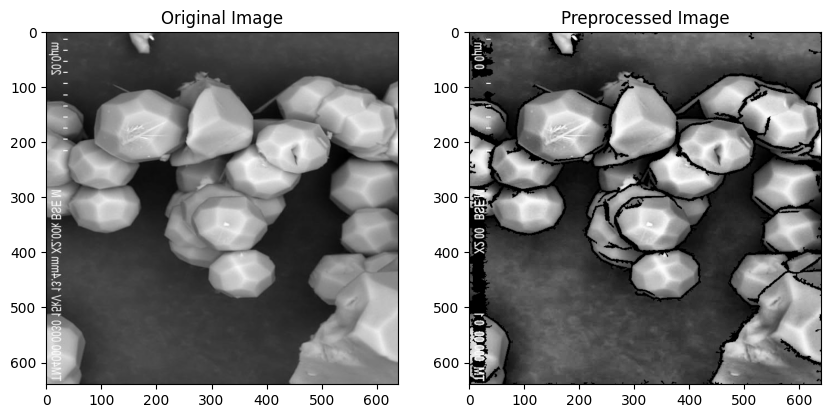

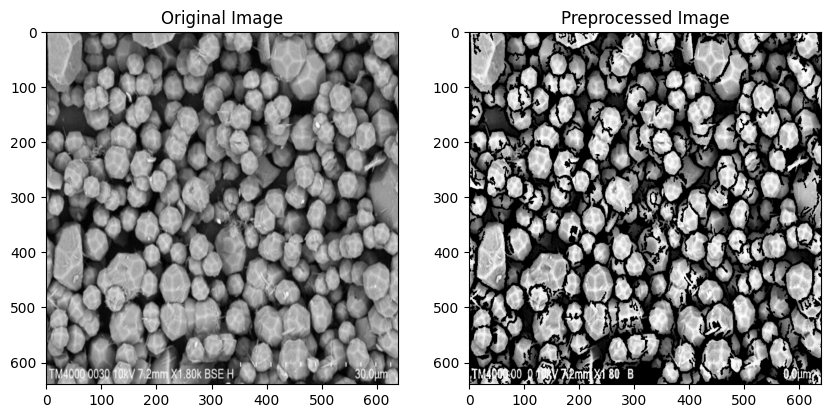

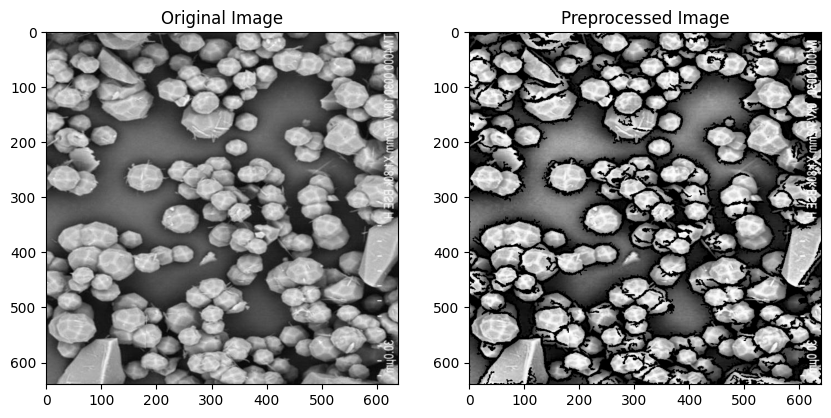

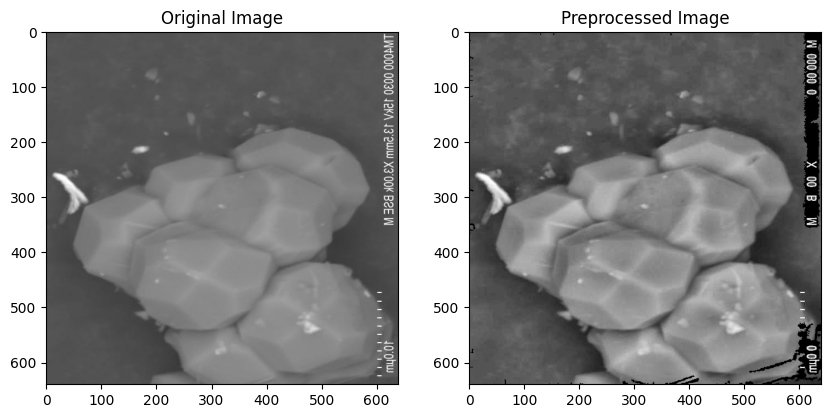

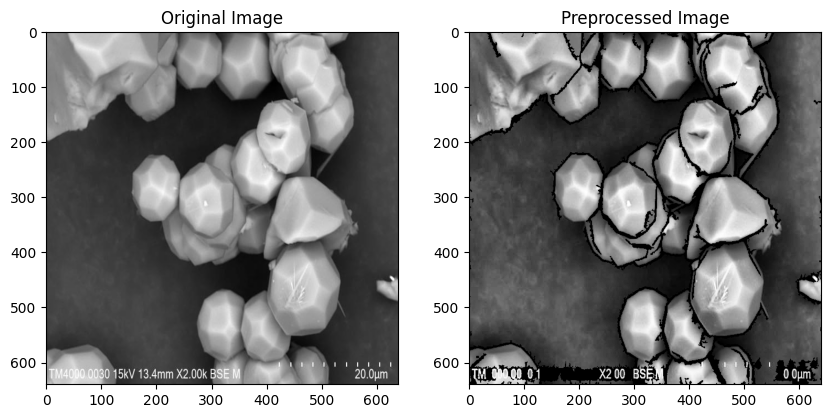

In [ ]:
display_preprocessed_images("annotation_cocoa_train", num_samples=5)

### Chạy tiền xử lý và lưu vào một thư mục mới

In [ ]:
# Hàm xử lý và lưu ảnh đã tiền xử lý
def process_and_save_images(dataset_name, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Lấy dữ liệu từ DatasetCatalog
        dataset_dicts = DatasetCatalog.get(dataset_name)

        for d in dataset_dicts:
            img = cv2.imread(d["file_name"])
            preprocessed_img = preprocess_image(img)
            output_path = os.path.join(output_dir, os.path.basename(d["file_name"]))
            print(f"Saving preprocessed image to {output_path}")
            cv2.imwrite(output_path, preprocessed_img)

In [ ]:
# Tiền xử lý, lưu ảnh vào thư mục mới. Sao chép file annotation sang thư mực mới
process_and_save_images("annotation_cocoa_train", "preprocessed_train/PNGImages")
!cp "/content/datasets/train/annotations_aistron.json" "/content/preprocessed_train"
process_and_save_images("annotation_cocoa_test", "preprocessed_test/PNGImages")
!cp "/content/datasets/test/annotations_aistron.json" "/content/preprocessed_test"

Saving preprocessed image to preprocessed_test/PNGImages/01.png
Saving preprocessed image to preprocessed_test/PNGImages/04-old.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateN90_flipH_01.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateN90_flipH_04-old.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateN90_flipV_01.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateN90_flipV_04-old.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateP90_flipH_01.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateP90_flipH_04-old.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateP90_flipV_01.png
Saving preprocessed image to preprocessed_test/PNGImages/_rotateP90_flipV_04-old.png


### Khai báo dataset đã tiền xử lý

In [ ]:
register_aistron_cocolike_instances(
    name ="preprocessed_train",
    metadata =get_default_metadata(),
    json_file = "/content/preprocessed_train/annotations_aistron.json",
    image_root ="/content/preprocessed_train")
register_aistron_cocolike_instances(
    name ="preprocessed_test",
    metadata =get_default_metadata(),
    json_file = "/content/preprocessed_test/annotations_aistron.json",
    image_root ="/content/preprocessed_test")

## Visualize dataset đã tiền xử lý

In [ ]:
#import cv2_imshow
from google.colab.patches import cv2_imshow
def visualize_dataset(dataset_name):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    for d in random.sample(dataset_dicts, 5):
        img = cv2.imread(d["file_name"])
        visualizer = AmodalVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name))
        vis = visualizer.draw_dataset_dict(d)
        cv2_imshow(vis.get_image()[:, :, ::-1])

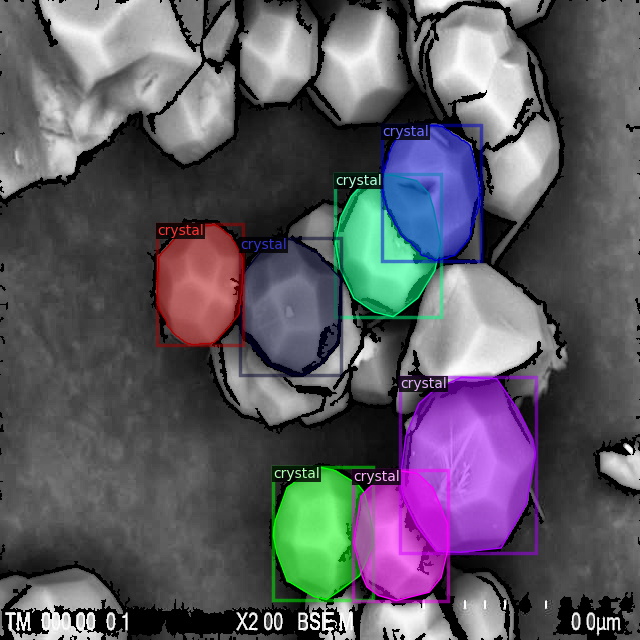

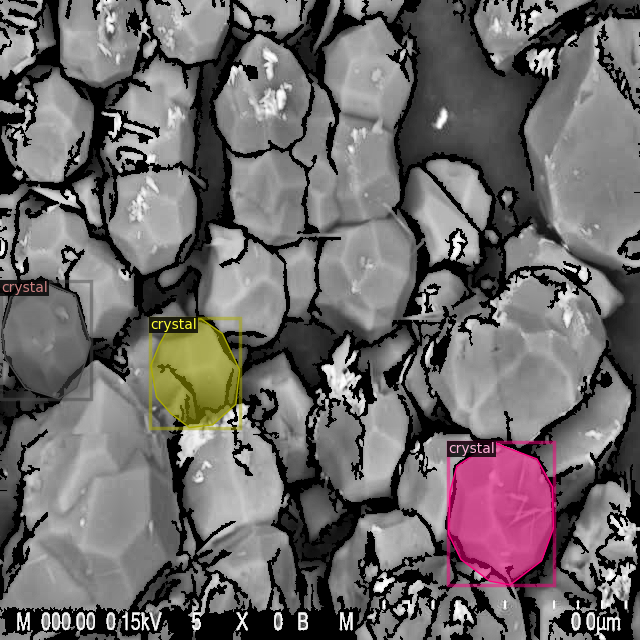

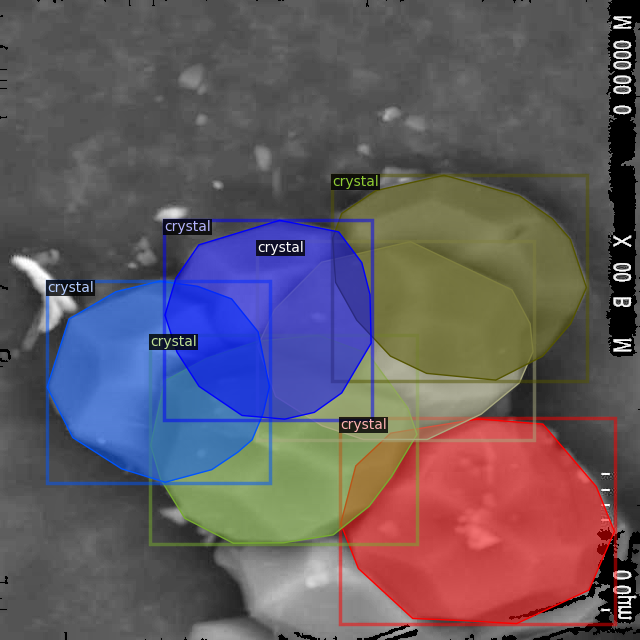

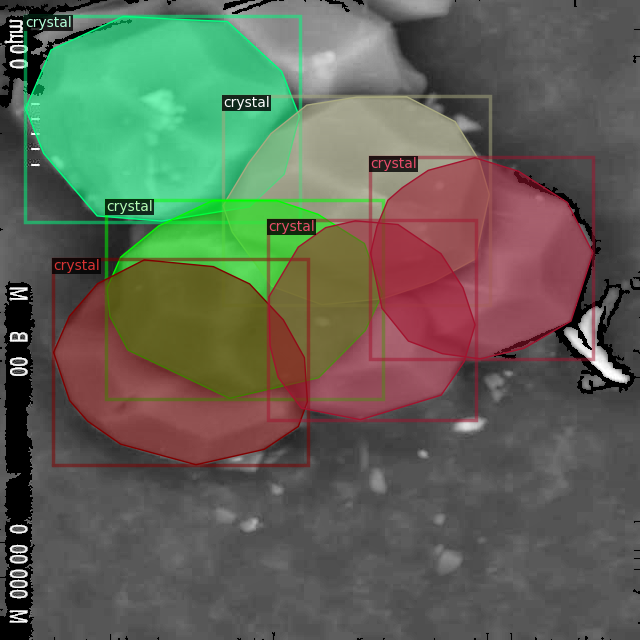

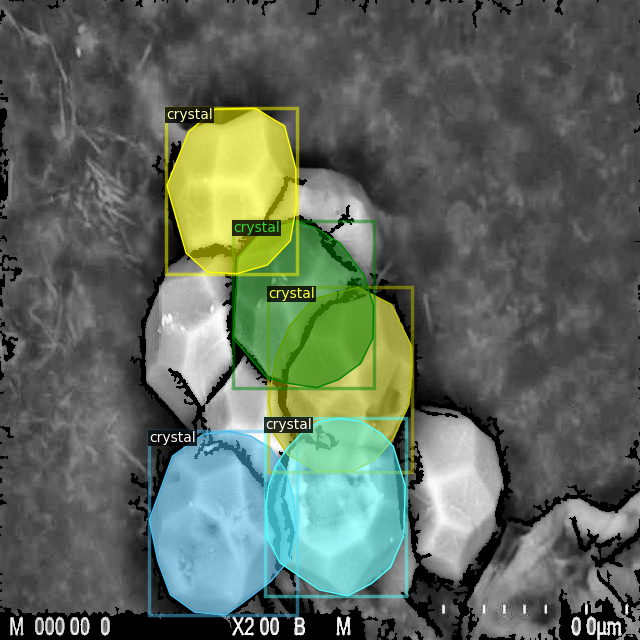

In [ ]:
visualize_dataset("preprocessed_train")

# Khai báo các thông số cho mô hình

 Lưu ý, có thể thay đổi đường dẫn config file để train nhiều mô hình khác nhau
 Một số config cho các mô hình được sử dụng trong đề tài khóa luận:
 - AIFormer-R50: /content/aistron/projects/AISFormer/configs/COCOA/aisformer_R50_FPN_cocoa_8ep_bs2.yaml
 - AISFormer-R101: /content/aistron/projects/AISFormer/configs/COCOA/aisformer_R101_FPN_cocoa_8ep_bs2.yaml
 - BCNet-R50: /content/aistron/projects/BCNet/configs/COCOA/bcnet_R50_FPN_cocoa_8ep_bs2.yaml
 - BCNet-R101: /content/aistron/projects/BCNet/configs/COCOA/bcnet_R101_FPN_cocoa_8ep_bs2.yaml

In [ ]:
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

from aistron.projects.aisformer import AISFormer, add_aisformer_config
from aistron.projects.bcnet import BCNet
###########
config_file = "/content/aistron/projects/AISFormer/configs/COCOA/aisformer_R50_FPN_cocoa_8ep_bs2.yaml" ## Thay đường dẫn config file vào đây !!!!!!!!
output_dir = "/content/data/train_outputs"
model_name = "maskrcnn_R50_FPN_cocoa_8ep_bs2"
model_file = f"/content/data/train_outputs/{model_name}.pth"
PREPROCESSED_DATASET_TRAIN = "preprocessed_train"
PREPROCESSED_DATASET_TEST = "preprocessed_test"
##########

cfg = get_cfg()
add_aistron_config(cfg)
if "bcnet" not in config_file:
  add_aisformer_config(cfg)
cfg.set_new_allowed(True)


cfg.SEED = 100
cfg.merge_from_file(config_file)

#if model_file exist
if os.path.exists(model_file):
  cfg.merge_from_list(model_file)
cfg.OUTPUT_DIR = output_dir
cfg.TEST.AUG.ENABLED = False
cfg.DATASETS.TRAIN = (PREPROCESSED_DATASET_TRAIN,)
cfg.DATASETS.TEST = (PREPROCESSED_DATASET_TEST,)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.MAX_ITER = 2500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (800,1500,2200)
cfg.TEST.EVAL_PERIOD = 500

cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA = 0.005

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 #your number of classes + 1

if torch.cuda.is_available():
    cfg.MODEL.DEVICE = 'cuda'
else:
    cfg.MODEL.DEVICE = 'cpu'


WARNING [07/10 15:01:23 d2.config.compat]: Config '/content/aistron/projects/AISFormer/configs/COCOA/aisformer_R50_FPN_cocoa_8ep_bs2.yaml' has no VERSION. Assuming it to be compatible with latest v2.


# Khai báo class AmodalCocoTrainer

In [ ]:
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.modeling import GeneralizedRCNNWithTTA
import logging
from collections import OrderedDict
class AmodalCocoTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = AmodalDatasetMapper(cfg, is_train=True)
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        mapper = AmodalDatasetMapper(cfg, is_train=False)
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return build_evaluator(cfg, dataset_name, output_folder)

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

# Khai báo hàm train

In [ ]:
import os
import shutil
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch

def train_model(resume=False):
    # Đường dẫn tới thư mục output
    output_dir = cfg.OUTPUT_DIR

    # Kiểm tra và xóa thư mục output nếu resume là False
    if not resume and os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        print(f"Output directory {output_dir} has been removed.")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AmodalCocoTrainer(cfg)
    trainer.resume_or_load(resume=resume)
    # Khởi tạo và huấn luyện mô hình
    if cfg.TEST.AUG.ENABLED:
        trainer.register_hooks(
            [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
        )
    trainer.train()

# Train !!!!

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
train_model(False)

[07/10 15:01:26 d2.engine.defaults]: Model:
GeneralizedRCNNAmodal(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_14d201.pkl: 185MB [00:01, 110MB/s]                           
backbone.fpn_lateral2.bias
backbone.fpn_lateral3.bias
backbone.fpn_lateral4.bias
backbone.fpn_lateral5.bias
backbone.fpn_output2.bias
backbone.fpn_output3.bias
backbone.fpn_output4.bias
backbone.fpn_output5.bias
proposal_generator.rpn_head.conv.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.mask_embed.layers.0.{bias, weight}


[07/10 15:01:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/10 15:02:06 d2.utils.events]:  eta: 1:01:25  iter: 19  total_loss: 4.29  loss_cls: 0.3935  loss_box_reg: 0.1416  loss_vi_mask: 0.6426  loss_bo_mask: 0.7179  loss_a_mask: 0.6216  loss_invisible_mask: 0.4223  loss_rpn_cls: 0.6789  loss_rpn_loc: 0.4452    time: 1.4714  last_time: 1.6671  data_time: 0.4326  last_data_time: 0.2293   lr: 0.00019081  max_mem: 6910M
[07/10 15:02:47 d2.utils.events]:  eta: 1:02:55  iter: 39  total_loss: 3.395  loss_cls: 0.404  loss_box_reg: 0.7864  loss_vi_mask: 0.5916  loss_bo_mask: 0.3596  loss_a_mask: 0.5037  loss_invisible_mask: 0.3538  loss_rpn_cls: 0.1698  loss_rpn_loc: 0.2306    time: 1.5942  last_time: 1.4674  data_time: 0.3189  last_data_time: 0.2806   lr: 0.00039061  max_mem: 7228M
[07/10 15:03:21 d2.utils.events]:  eta: 1:04:50  iter: 59  total_loss: 3.142  loss_cls: 0.4127  loss_box_reg: 0.8765  loss_vi_mask: 0.5278  loss_bo_mask: 0.3081  loss_a_mask: 0.4494  loss_invisible_mask: 0.3332  loss_rpn_cls: 0.0897  loss_rpn_loc: 0.1309    time: 1.6308

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 15:16:10 d2.evaluation.evaluator]: Total inference time: 0:00:01.842085 (0.368417 s / iter per device, on 1 devices)
[07/10 15:16:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.195060 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=0.72s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 15:30:49 d2.evaluation.evaluator]: Total inference time: 0:00:01.955592 (0.391118 s / iter per device, on 1 devices)
[07/10 15:30:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.193127 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=0.71s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 15:45:20 d2.evaluation.evaluator]: Total inference time: 0:00:02.488639 (0.497728 s / iter per device, on 1 devices)
[07/10 15:45:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.193749 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=1.31s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 15:59:48 d2.evaluation.evaluator]: Total inference time: 0:00:01.910323 (0.382065 s / iter per device, on 1 devices)
[07/10 15:59:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.191014 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=0.71s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 16:14:17 d2.evaluation.evaluator]: Total inference time: 0:00:02.147771 (0.429554 s / iter per device, on 1 devices)
[07/10 16:14:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.191803 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=1.24s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

# Đánh giá mô hình

In [ ]:
# Import một số hàm hỗ trợ
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import inference_on_dataset
#import /content/demo/predictor.py
def eval_amodal(trainerAmodal):
    # Điều chỉnh một số thông số phù hợp cho việc kiểm thử
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

    # Đánh giá mô hình trên tập dữ liệu test
    predictor = DefaultPredictor(cfg)
    evaluator = AmodalInstanceEvaluator(PREPROCESSED_DATASET_TEST, cfg, False, output_dir="./output/")
    val_loader = trainerAmodal.build_test_loader(cfg, PREPROCESSED_DATASET_TEST)
    inference_on_dataset(trainerAmodal.model, val_loader, evaluator)
trainer = AmodalCocoTrainer(cfg)
trainer.resume_or_load(resume=True)
eval_amodal(trainer)

[07/10 16:14:23 d2.engine.defaults]: Model:
GeneralizedRCNNAmodal(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/10 16:14:23 d2.engine.hooks]: Loading scheduler from state_dict ...
[07/10 16:14:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/data/train_outputs/model_final.pth ...


[07/10 16:14:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/10 16:14:25 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[07/10 16:14:25 d2.data.common]: Serialized dataset takes 0.98 MiB
[07/10 16:14:25 d2.evaluation.evaluator]: Start inference on 10 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/10 16:14:32 d2.evaluation.evaluator]: Total inference time: 0:00:01.990291 (0.398058 s / iter per device, on 1 devices)
[07/10 16:14:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.188345 s / iter per device, on 1 devices)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *amodal_segm*
DONE (t=1.28s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

# Chạy inference từ mô hình đã trained

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
import atexit
import bisect
import multiprocessing as mp
import numpy as np
from collections import deque
import cv2
import torch

from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.utils.visualizer import ColorMode
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import Visualizer, ColorMode, _create_text_labels, GenericMask
from detectron2.data import MetadataCatalog


import logging
from collections import OrderedDict
from aistron.utils.visualizer import AmodalVisualizer
from aistron.data import AmodalDatasetMapper
from aistron.evaluation import AmodalInstanceEvaluator


class VisualizationDemo(object):
    def __init__(self, cfg, instance_mode=ColorMode.SEGMENTATION, parallel=False):
        """
        Args:
            cfg (CfgNode):
            instance_mode (ColorMode):
            parallel (bool): whether to run the model in different processes from visualization.
                Useful since the visualization logic can be slow.
        """
        self.metadata = MetadataCatalog.get(
            cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
        )
        self.cpu_device = torch.device("cpu")
        self.instance_mode = instance_mode

        self.parallel = parallel
        if parallel:
            num_gpu = torch.cuda.device_count()
            self.predictor = DefaultPredictor(cfg)
        else:
            self.predictor = DefaultPredictor(cfg)

    def run_on_image(self, image, segm_type='amodal'):
            """
            Args:
                image (np.ndarray): an image of shape (H, W, C) (in BGR order).
                    This is the format used by OpenCV.

            Returns:
                predictions (dict): the output of the model.
                vis_output (VisImage): the visualized image output.
            """
            vis_output = None
            predictions = self.predictor(image)
            # Convert image from OpenCV BGR format to Matplotlib RGB format.
            image = image[:, :, ::-1]
            visualizer = AmodalVisualizer(image, self.metadata, instance_mode=self.instance_mode)
            if "panoptic_seg" in predictions:
                panoptic_seg, segments_info = predictions["panoptic_seg"]
                vis_output = visualizer.draw_panoptic_seg_predictions(
                    panoptic_seg.to(self.cpu_device), segments_info
                )
            else:
                if "sem_seg" in predictions:
                    vis_output = visualizer.draw_sem_seg(
                        predictions["sem_seg"].argmax(dim=0).to(self.cpu_device)
                    )
                if "instances" in predictions:
                    instances = predictions["instances"].to(self.cpu_device)
                    vis_output = visualizer.draw_instance_predictions(predictions=instances, segm_type=segm_type)

            return predictions, vis_output

# Show hình ảnh sau khi nhận diện

In [ ]:
import random
import cv2
import numpy as np
from detectron2.utils.visualizer import Visualizer
from IPython.display import display, Image
from detectron2.data import MetadataCatalog, DatasetCatalog
import logging
from PIL import Image
from IPython.display import display
import time
from aistron.config import add_aistron_config
from aistron.projects.bcnet import BCNet
from aistron.projects.aisformer import AISFormer, add_aisformer_config

#import VisualizationDemo in /content/demo/predictor.py
from aistron.projects.aisformer import AISFormer, add_aisformer_config
from aistron.projects.bcnet import BCNet
from aistron.utils.visualizer import AmodalVisualizer
from aistron.data import AmodalDatasetMapper
from aistron.evaluation import AmodalInstanceEvaluator
import os


# Hàm load ảnh từ dataset, nhận diện tinh thể trong ảnh và hiển thị
# cùng với ảnh được dán nhãn thủ công bằng tay
def show_demo_inference_image_from_dataset(dataset_dicts, sample_size = 5):
  for d in random.sample(dataset_dicts, sample_size):
    print(d["file_name"])
    img_origin = cv2.imread(d["file_name"])
    # img = preprocess_image(img_origin)
    img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    predictions, visualized_output = predictor.run_on_image(img,segm_type  = 'amodal')
    #start_time = time.time()
    v = Visualizer(img, metadata=test_metadata, scale=1)
    out = v.draw_instance_predictions(predictions["instances"].to("cpu"))
    visualizer = Visualizer(img[:, :, ::-1],scale=1,metadata=test_metadata)
    vis = visualizer.draw_dataset_dict(d)
    ############ GET IMAGE
    image_input_draw = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    image_output_draw = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    image_input_draw = cv2.resize(image_input_draw, (image_output_draw.shape[0], image_output_draw.shape[1]))
    line_thickness = 3
    line = np.zeros((image_input_draw.shape[0], line_thickness, 3), dtype=image_input_draw.dtype)
    ########### COMBINED
    combined = np.concatenate((image_input_draw, line, image_output_draw), axis=1)
    cv2_imshow(combined)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/data/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = VisualizationDemo(cfg)
test_metadata = MetadataCatalog.get(PREPROCESSED_DATASET_TEST)
dataset_dictionaries = DatasetCatalog.get(PREPROCESSED_DATASET_TEST)
show_demo_inference_image_from_dataset(dataset_dictionaries)

# Sao chép kết quả về Drive của bạn để lưu trữ (optional)

In [ ]:
# from datetime import date

# today = date.today()

# out_model_path = f"/content/drive/MyDrive/data_{today}_AISFormer_R50/"

# #copy /data to drive
# import os
# os.makedirs(out_model_path, exist_ok=True)

# !cp -r /content/data/* {out_model_path}